<!--NAVIGATION-->

_______________
Este documento puede ser utilizado de forma interactiva en las siguientes plataformas: 

- [Google Colab](https://colab.research.google.com/github/masdeseiscaracteres/ml_course/blob/master/material/07_SVMs_and_kernel_methods.ipynb)
- [MyBinder](https://mybinder.org/v2/gh/masdeseiscaracteres/ml_course/master)
- [Deepnote](https://deepnote.com/launch?template=python_3.6&url=https%3A%2F%2Fgithub.com%2Fmasdeseiscaracteres%2Fml_course%2Fblob%2Fmaster%2Fmaterial%2F07_SVMs_and_kernel_methods.ipynb)


_______________

# SVM y métodos kernel

Aquí vamos a poner a prueba el algoritmo de SVMs, tanto en problemas de clasificación como de regresión. Adicionalmente, se analizará el funcionamiento de otros métodos que utilizan el concepto de [kernel](https://en.wikipedia.org/wiki/Kernel_method). 

Estos serán los contenidos:

1. SVMs en problemas de clasificación
  1. Ejemplos sintéticos
  2. Ejemplo realista ([Pima Indian Diabetes dataset](https://www.kaggle.com/uciml/pima-indians-diabetes-database))
2. SVMs en problemas de regresión
  1. Ejemplo sintético
  2. Ejemplo realista ([House Sales in King County, USA](https://www.kaggle.com/harlfoxem/housesalesprediction))
3. Otros métodos Kernel
  1. Kernel Ridge Regression
  2. Kernel PCA

## 0. Configuración del entorno

In [1]:
# clonar el resto del repositorio si no está disponible
import os
curr_dir = os.getcwd()
if not os.path.exists(os.path.join(curr_dir, '../.ROOT_DIR')):
    !git clone https://github.com/masdeseiscaracteres/ml_course.git ml_course
    os.chdir(os.path.join(curr_dir, 'ml_course/material'))

Lo primero es cargar las librerías y funciones necesarias.

In [2]:
# cargamos librerías necesarias
import numpy  as np  
import pandas as pd

import matplotlib.pyplot as plt # para dibujar
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

In [3]:
# definimos una función para representar el resultado del ajuste
def plot_decision_boundary_svm(X,y,h,model):
    
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = .05  # step size in the mesh
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    Zd = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Zd = Zd.reshape(xx.shape)
    
    Zp = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1] 
    Zp = Zp.reshape(xx.shape)
    
    # Error de clasificación
    ypred = model.predict(X)
    acc = accuracy_score(y, ypred)
    
    plt.figure(1, figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,c='k', facecolors='none')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.axis([x_min, x_max, y_min, y_max])
    plt.contour(xx, yy, Zd, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'], levels=[-1, 0, 1])
    plt.contourf(xx, yy, Zd>0, cmap=cm, alpha=.5)
    plt.xlabel("$x_1$", fontsize=16)
    plt.ylabel("$x_2$", fontsize=16)
    msg = 'FRONTERA DECISION\n Accuracy: %0.2g' % acc
    plt.title(msg)
        
    plt.subplot(1, 2, 2)
    plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,c='k', facecolors='none')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.axis([x_min, x_max, y_min, y_max])
    plt.contour(xx, yy, Zd, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'], levels=[-1, 0, 1])
    plt.contourf(xx, yy, Zp, cmap=cm, alpha=.5)
    plt.xlabel("$x_1$", fontsize=16)
    plt.ylabel("$x_2$", fontsize=16)
    msg = 'PROBABILIDAD\n Accuracy: %0.2g' % acc
    plt.title(msg)
    
    plt.tight_layout()
    plt.show()

## 1. SVMs en problemas de clasificación

Comenzaremos analizando las máquinas de vectores soporte (SVM) en clasificación, en ocasiones denominadas *Support Vector Classifiers* (SVC). Primero probaremos sobre ejemplos sintéticos.

### 1.1. Ejemplos sintéticos

Cargamos y representamos nuestros ejemplos.

In [4]:
# ejemplo1
ejemplo1 = pd.read_csv("./data/ex2data1.txt", sep=",", header=None, names=['x1', 'x2','label'])

# ejemplo2
ejemplo2 = pd.read_csv("./data/ex2data2.txt", sep=",", header=None, names=['x1', 'x2','label'])

# ejemplo 3: Problema XOR 
np.random.seed(0)

# -- parameters
N     = 800
mu    = 1.5      # Cambia este valor
sigma = 1      # Cambia este valor

# variables auxiliares
unos = np.ones(int(N/4))
random4 = sigma*np.random.randn(int(N/4),1)
random2 = sigma*np.random.randn(int(N/2),1)

# -- features
y3 = np.concatenate([-1*unos,       unos,          unos,         -1*unos]) 
X1 = np.concatenate([-mu + random4, mu + random4, -mu + random4, mu + random4])
X2 = np.concatenate([+mu + random2,               -mu + random2])
X3 = np.hstack((X1,X2))

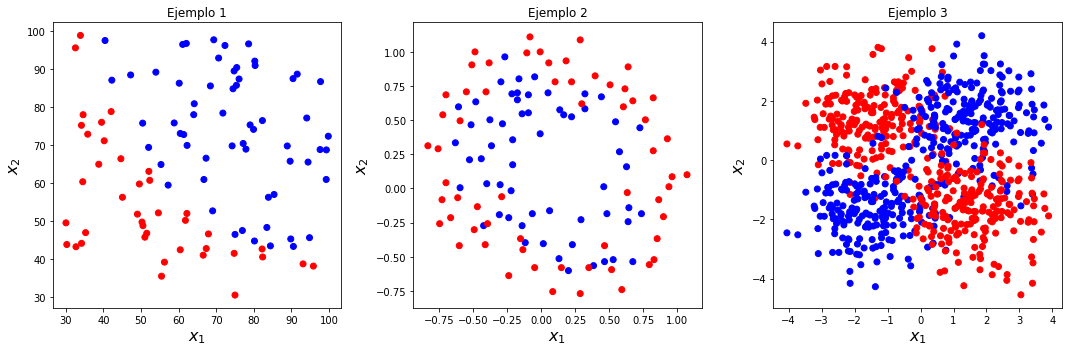

In [5]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(ejemplo1['x1'], ejemplo1['x2'], c=ejemplo1['label'], cmap=cm_bright)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)
plt.title('Ejemplo 1')

plt.subplot(1, 3, 2)
plt.scatter(ejemplo2['x1'], ejemplo2['x2'], c=ejemplo2['label'], cmap=cm_bright)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)
plt.title('Ejemplo 2')

plt.subplot(1, 3, 3)
plt.scatter(X3[:,0], X3[:,1], c=y3, cmap=cm_bright)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)
plt.title('Ejemplo 3')

plt.tight_layout()
plt.show()

#### Ejemplo 1

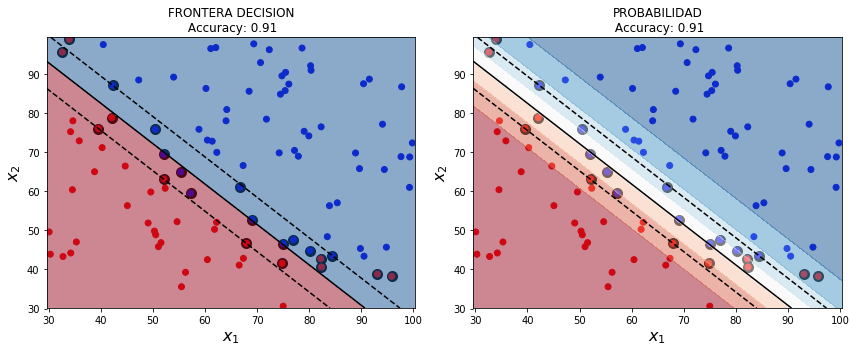

In [6]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Ejemplo 1
# preparamos los datos
data1 = ejemplo1.values
X1 = data1[:,0:2]
y1 = data1[:,-1]

# creamos el modelo y ajustamos
svm_model1 = SVC(kernel='linear', probability = True)
svm_model1.fit(X1,y1)

plot_decision_boundary_svm(X1, y1, 0.05, svm_model1)

En el gráfico anterior hemos resaltado los **vectores soporte**, la **frontera de separación** y el **margen**. 

Como el problema no es linealmente separable, observamos errores de clasificación que caen tanto dentro del margen, como al otro lado de la frontera de separación correspondiente. 

Sabemos que podemos permitir ciertos errores dentro del margen, y los penalizamos con un coste $C$. 

- Si tenemos un valor elevado del coste $C$, estaremos penalizando mucho los errores, y por tanto se obtienen fronteras más ajustadas (mayor complejidad, mayor riesgo de overfitting, potencialmente, mejores prestaciones). 

- Por otro lado, si tenemos un valor pequeño del coste $C$, no daremos mucha importancia a los errores, y por tanto se obtienen fronteras menos ajustadas (menor complejidad, menor riesgo de overfitting, potencialmente, peores prestaciones). 

Se puede modificar el coste $C$ mediante el parámetro de mismo nombre en `scikit-learn`. Por defecto, $C=1$.

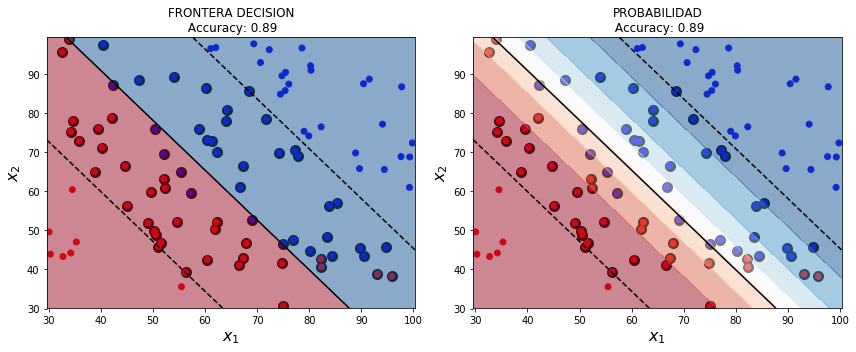

In [7]:
svm_model1 = SVC(kernel='linear', probability=True, C=1e-4) # PIENSA ANTES COMO SERÁ EL RESULTADO
svm_model1.fit(X1, y1)

plot_decision_boundary_svm(X1, y1, 0.05, svm_model1)

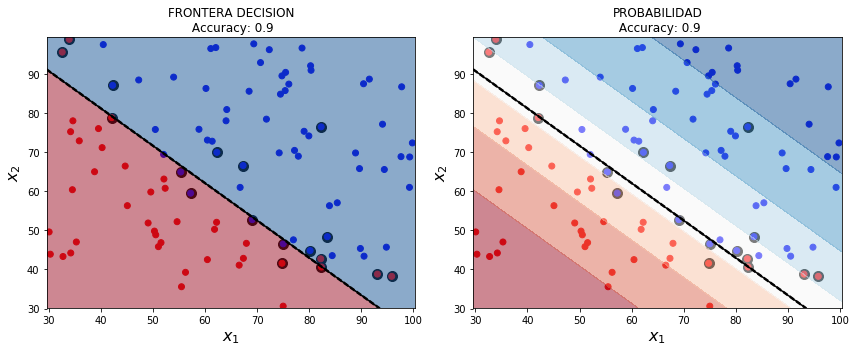

In [8]:
svm_model1 = SVC(kernel='linear', probability=True, C=1e5) # PIENSA ANTES COMO SERÁ EL RESULTADO
svm_model1.fit(X1, y1)

plot_decision_boundary_svm(X1, y1, 0.05, svm_model1)

### Ejemplos 2 y 3

Comenzamos por el ejemplo 2.

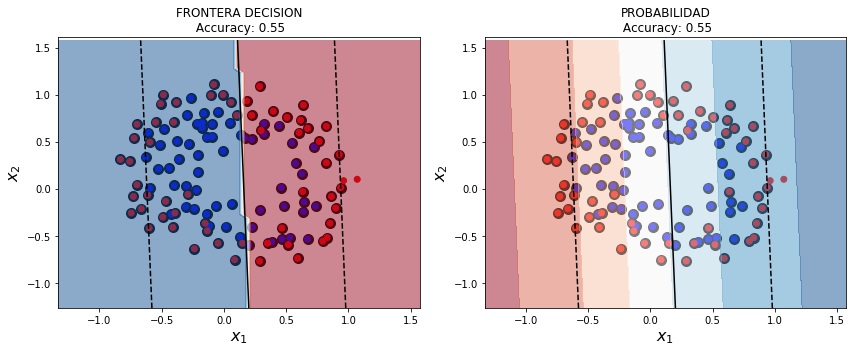

In [9]:
# preparamos los datos
data2 = ejemplo2.values
X2 = data2[:,0:2]
y2 = data2[:,-1]

# creamos el modelo
svm_model2 = SVC(kernel='linear', probability=True)
svm_model2.fit(X2, y2)

plot_decision_boundary_svm(X2, y2, 0.05, svm_model2)

Como podemos comprobar, un kernel lineal no nos sirve para generar una frontera de separación no lineal, así que tenemos que utilizar otros kernels.

#### Ejercicio
Echa un vistazo a la documentación para conocer cómo entrenar un algoritmo [SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) con diferentes *kernels*. Prueba distintos *kernels* con distintos valores de sus parámetros libres.

#### Solución

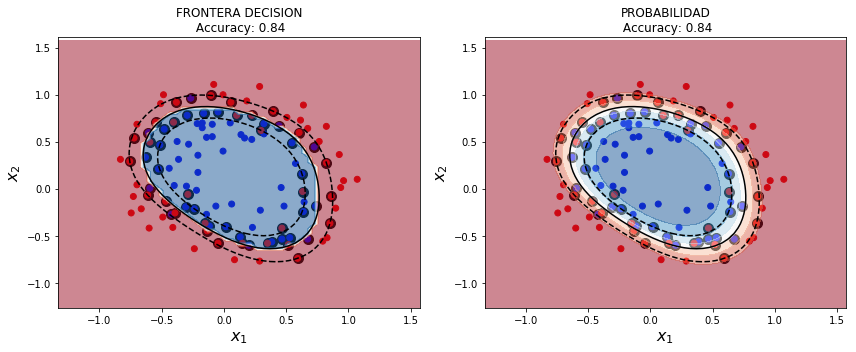

In [10]:
# RBF
svm_model2 = SVC(kernel='rbf', gamma=1, C = 10, probability=True)
svm_model2.fit(X2, y2)

plot_decision_boundary_svm(X2, y2, 0.05, svm_model2)

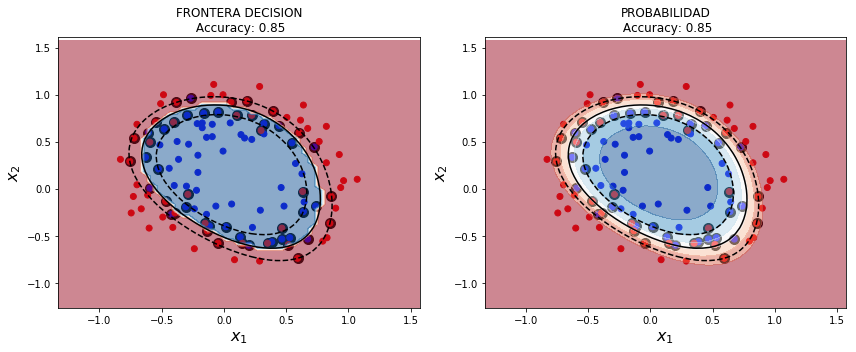

In [11]:
# Polinómico
svm_model2 = SVC(kernel='poly', gamma=1.0, coef0=1.0, C = 10, probability=True)
svm_model2.fit(X2, y2)

plot_decision_boundary_svm(X2, y2, 0.05, svm_model2)

#### Ejercicio
Entrena una SVM sobre el ejemplo 3.

#### Solución

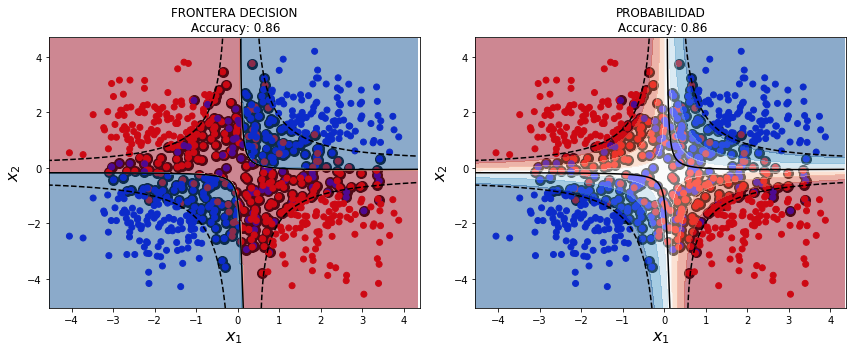

In [12]:
# Ejemplo 3
svm_model3 = SVC(kernel='rbf', gamma=0.01, C=10, probability=True).fit(X3, y3)
plot_decision_boundary_svm(X3, y3, 0.05, svm_model3)

#### Ejercicio
Suponiendo un kernel RBF, calcule el valor óptimo de `C` y `gamma` para el ejemplo 3, ¿cuáles son las prestaciones del algoritmo para este ejemplo?

#### Solución

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best mean cross-validation score: 0.870
best parameters: {'C': 0.0630957344480193, 'gamma': 1.2589254117941662}
best parameters: {'C': -1.2000000000000002, 'gamma': 0.09999999999999964}


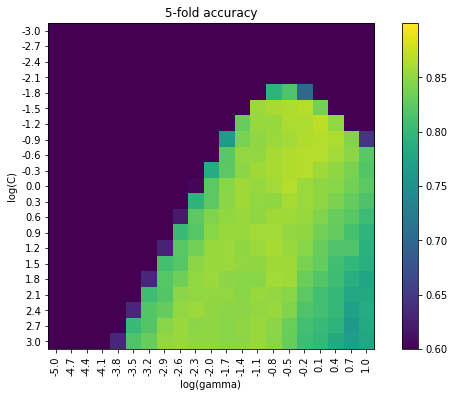

Accuracy (TEST): 0.85
Accuracy (TRAIN): 0.87


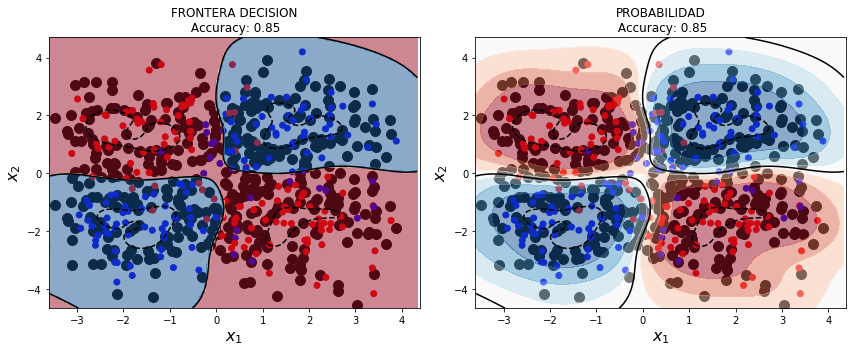

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Paso 1:
X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size=0.3, shuffle=True, random_state=0)

# Paso 2:
vectorC = np.logspace(-3, 3, 21)
vectorG = np.logspace(-5, 1, 21)

param_grid = {'C': vectorC,
              'gamma': vectorG}

n_folds = 5

grid = GridSearchCV(SVC(kernel='rbf'), scoring='accuracy', param_grid=param_grid, cv=n_folds)
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("best parameters: {}".format({k: np.log10(v) for k,v in grid.best_params_.items()}))

# Mostramos prestaciones en CV
scores = grid.cv_results_['mean_test_score'].reshape(len(vectorC),len(vectorG))

plt.figure(figsize=(10, 6))
plt.imshow(scores, interpolation='nearest', vmin=0.6, vmax=0.9)
plt.xlabel('log(gamma)')
plt.ylabel('log(C)')
plt.colorbar()
plt.xticks(np.arange(len(vectorG)), np.round(np.log10(vectorG),decimals=1), rotation=90)
plt.yticks(np.arange(len(vectorC)), np.round(np.log10(vectorC),decimals=1))
plt.title('{}-fold accuracy'.format(n_folds))
plt.show()

# Paso 3: mostramos prestaciones en test
Copt = grid.best_params_['C']
Gopt = grid.best_params_['gamma']

svm_model3 = SVC(kernel='rbf', gamma=Gopt, C=Copt, probability=True).fit(X_train, y_train)

print('Accuracy (TEST): %0.2f' % svm_model3.score(X_test, y_test))
print('Accuracy (TRAIN): %0.2f' % svm_model3.score(X_train, y_train))

plot_decision_boundary_svm(X_test, y_test, 0.05, svm_model3)

### 1.2. Ejemplo realista

Vamos a utilizar el conjunto de datos [Pima Indian Diabetes dataset](https://www.kaggle.com/uciml/pima-indians-diabetes-database).

In [14]:
# cargamos datos
data = pd.read_csv('./data/diabetes.csv', sep=',', decimal='.')

# preparamos los datos
features = data.columns.drop(['Outcome'])
X = data[features].values
y = data['Outcome'].values

print('Dimensionalidad datos: ', X.shape)

Dimensionalidad datos:  (768, 8)


#### Ejercicio
Ajuste un modelo de SVM al conjunto de datos anterior y devuelva las prestaciones en el conjunto de test.  

#### Solución

In [15]:
#Paso 1: Divisón train-test
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, 
                                                    test_size=0.2, random_state=0)

print('Datos train: ', X_train.shape)
print('Datos test: ', X_test.shape)

print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

Datos train:  (614, 8)
Datos test:  (154, 8)
(array([0, 1]), array([400, 214]))
(array([0, 1]), array([100,  54]))


In [16]:
# Paso 2: Búsqueda de parámetros libres
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

vectorC = np.logspace(-1, 3, 20)
vectorG = np.logspace(-9, -1, 20)

param_grid = {'C': vectorC, 'gamma': vectorG}

n_folds = 3

clf = SVC(kernel='rbf')
grid = GridSearchCV(clf, scoring='accuracy', param_grid=param_grid, cv=n_folds)
grid.fit(X_train, y_train)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.00000e-01, 1.62378e-01, 2.63665e-01, 4.28133e-01, 6.95193e-01,
       1.12884e+00, 1.83298e+00, 2.97635e+00, 4.83293e+00, 7.84760e+00,
       1.27427e+01, 2.06914e+01, 3.35982e+01, 5.45559e+01, 8.85867e+01,
       1.43845e+02, 2.33572e+02, 3.79269e+02, 6.15848e+02, 1.00000e... 2.97635e-04, 7.84760e-04,
       2.06914e-03, 5.45559e-03, 1.43845e-02, 3.79269e-02, 1.00000e-01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

best mean cross-validation score: 0.764
best parameters: {'C': 88.58667904100822, 'gamma': 2.335721469090121e-06}


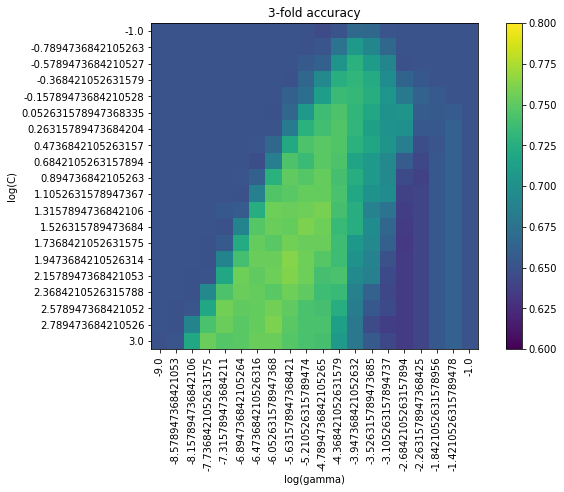

In [17]:
# Representación de prestaciones
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = grid.cv_results_['mean_test_score'].reshape(len(vectorC),len(vectorG))

plt.figure(figsize=(10,6))
plt.imshow(scores, interpolation='nearest', vmin=0.6, vmax=0.8)
plt.xlabel('log(gamma)')
plt.ylabel('log(C)')
plt.colorbar()
plt.xticks(np.arange(len(vectorG)), np.log10(vectorG), rotation=90)
plt.yticks(np.arange(len(vectorC)), np.log10(vectorC))
plt.title('{}-fold accuracy'.format(n_folds))
plt.show()

In [18]:
# Paso 3: Evaluación de resultados
Copt = grid.best_params_['C']
Gopt = grid.best_params_['gamma']

svm = SVC(kernel='rbf', gamma=Gopt, C=Copt)
svm.fit(X_train, y_train)

print('Accuracy (TEST): %0.3f' % svm.score(X_test, y_test))
print('Accuracy (TRAIN): %0.3f' % svm.score(X_train, y_train))

Accuracy (TEST): 0.779
Accuracy (TRAIN): 0.770


## 2. SVMs en problemas de regresión

El algoritmo SVM en regresión se denomina *Support Vector Regression* ([SVR](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)).

### 2.1 Ejemplo sintético

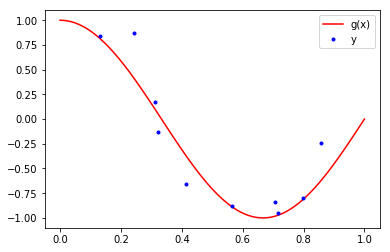

In [19]:
N_train = 10
N_test  = 100

# función verdadera g(x)
x = np.linspace(0, 1, N_test)
g_x = np.cos(1.5 * np.pi * x)

# proceso y
np.random.seed(0) # para asegurar reproducibilidad
epsilon = np.random.randn(N_test) * 0.2
y = g_x + epsilon

# Datos: D = {x_i,y_i}, obtenemos una muestra
idx = np.random.randint(0, N_test, N_train)
x_i = x[idx]
y_i = y[idx]

# Dibujamos la función g(x), y el conjunto de datos x_i,y_i
plt.plot(x, g_x, 'r', label='g(x)')
plt.plot(x_i, y_i, 'b.', label='y')
plt.legend()
plt.show()

#### Ejercicio
Ajusta un modelo SVR para el ejemplo anterior.

#### Solución

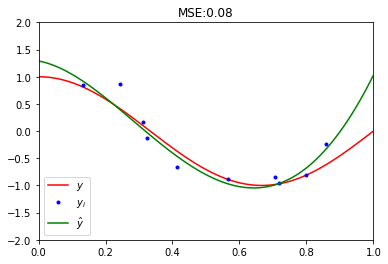

In [20]:
from sklearn.svm import SVR

# datos
X_train = x_i.reshape(-1, 1)
y_train = y_i
X_test  = x.reshape(-1, 1)

# definimos modelo
#svr = SVR(kernel='linear', C=10).fit(X_train, y_train)
#svr = SVR(kernel='rbf', gamma=10, C=10).fit(X_train, y_train)
svr = SVR(kernel='poly', gamma='auto', degree=5, coef0=4, C=100).fit(X_train, y_train)

# predicción
y_hat = svr.predict(X_test)

# error test
error_test = np.mean(np.power(y - y_hat,2)) 

# representamos
plt.plot(x, g_x, 'r', label='$y$')
plt.plot(x_i, y_i, 'b.', label='$y_i$')
plt.plot(x, y_hat, 'g', label='$\hat{y}$')
plt.title('MSE:%.2f' % error_test)
plt.legend()
plt.xlim((0, 1))
plt.ylim((-2, 2))
plt.show()

### 2.2 Ejemplo realista en regresión

Utilizaremos el conjunto de datos `kc_house_data.csv`:

In [21]:
# cargamos datos
house_data = pd.read_csv("./data/kc_house_data.csv") # cargamos fichero

# Eliminamos las columnas id y date 
house_data = house_data.drop(['id', 'date'], axis=1)

# convertir las variables en pies al cuadrado en metros al cuadrado 
feetFeatures = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']
house_data[feetFeatures] = house_data[feetFeatures].apply(lambda x: x * 0.3048 * 0.3048)

# renombramos
house_data.columns = ['price','bedrooms','bathrooms','sqm_living','sqm_lot','floors','waterfront','view','condition',
                      'grade','sqm_above','sqm_basement','yr_built','yr_renovated','zip_code','lat','long',
                      'sqm_living15','sqm_lot15']

# convertimos el DataFrame al formato necesario para scikit-learn
data = house_data.values 

y = data[:,0]     # nos quedamos con la 1ª columna, price
X = data[:,1:]      # nos quedamos con el resto

feature_names = house_data.columns[1:]

In [22]:
# Paso 1: División en train y test, y escalado de los datos
from sklearn import preprocessing


X_train, X_test, y_train, y_test = train_test_split(X, np.log10(y), test_size=.25, random_state=2)

print('Datos entrenamiento: ', X_train.shape)
print('Datos test: ', X_test.shape)

scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

Datos entrenamiento:  (16209, 18)
Datos test:  (5404, 18)


La siguiente celda tarda en ejecutarse un tiempo (del orden de 1 hora).

In [23]:
# Paso 2: búsqueda de hiperparámetros en rejilla
vectorC = np.logspace(-2, 2, 10)
vectorG = np.logspace(-5, 1, 8)

param_grid = {'C': vectorC, 'gamma': vectorG}

n_folds = 5

grid = GridSearchCV(SVR(kernel='rbf'), param_grid=param_grid, cv=n_folds, verbose=1)
grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed: 106.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.00000e-02, 2.78256e-02, 7.74264e-02, 2.15443e-01, 5.99484e-01,
       1.66810e+00, 4.64159e+00, 1.29155e+01, 3.59381e+01, 1.00000e+02]), 'gamma': array([1.00000e-05, 7.19686e-05, 5.17947e-04, 3.72759e-03, 2.68270e-02,
       1.93070e-01, 1.38950e+00, 1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

best mean cross-validation score: 0.857
best parameters: {'C': 4.6415888336127775, 'gamma': 0.026826957952797246}


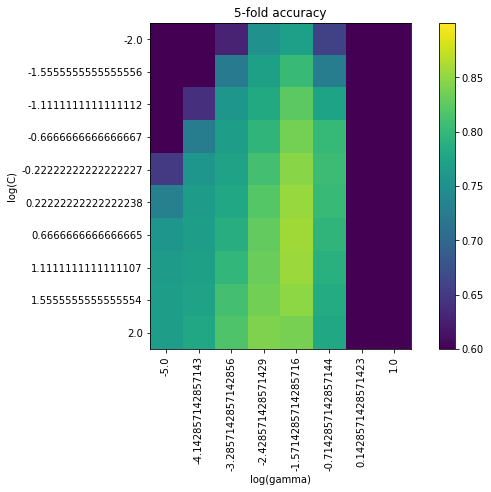

In [24]:
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

# Mostramos prestaciones en CV
scores = grid.cv_results_['mean_test_score'].reshape(len(vectorC), len(vectorG))

plt.figure(figsize=(10, 6))
plt.imshow(scores, interpolation='nearest', vmin=0.6, vmax=0.9)
plt.xlabel('log(gamma)')
plt.ylabel('log(C)')
plt.colorbar()
plt.xticks(np.arange(len(vectorG)), np.log10(vectorG), rotation=90)
plt.yticks(np.arange(len(vectorC)), np.log10(vectorC))
plt.title('{}-fold accuracy'.format(n_folds))
plt.show()

In [25]:
# Paso 3: evaluación de resultados
Copt = grid.best_params_['C']
Gopt = grid.best_params_['gamma']

svm_model = SVR(kernel='rbf', gamma=Gopt, C=Copt)
svm_model.fit(X_train_scaled, y_train)
print('Accuracy (TEST): %0.2f' % svm_model.score(X_test_scaled, y_test))

Accuracy (TEST): 0.86


Este problema es suficientemente complejo como para ser analizado en una [tesis de máster](http://scholarworks.sjsu.edu/cgi/viewcontent.cgi?article=1540&context=etd_projects).

## 3. Otros métodos Kernel

### 3.1. Kernel Ridge Regression

Vemos un ejemplo sencilo de [Kernel Ridge Regression](http://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html#sklearn.kernel_ridge.KernelRidge):

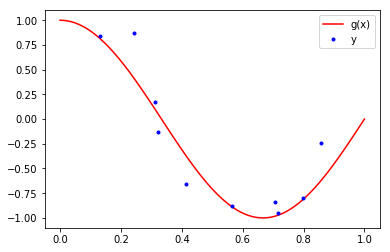

In [26]:
N_train = 10
N_test  = 100

# función verdadera g(x)
x = np.linspace(0, 1, N_test)
g_x = np.cos(1.5 * np.pi * x)

# proceso y
np.random.seed(0) # para asegurar reproducibilidad
epsilon = np.random.randn(N_test) * 0.2
y = g_x + epsilon

# Datos: D = {x_i,y_i}, obtenemos una muestra
idx = np.random.randint(0, N_test, N_train)
x_i = x[idx]
y_i = y[idx]

# Dibujamos la función g(x), y el conjunto de datos x_i,y_i
plt.plot(x, g_x, 'r', label='g(x)')
plt.plot(x_i, y_i, 'b.', label='y')
plt.legend()
plt.show()

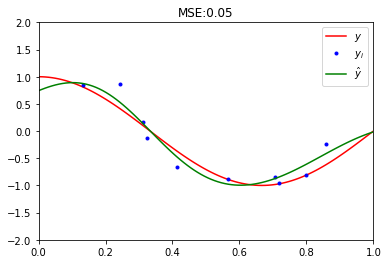

In [27]:
from sklearn.kernel_ridge import KernelRidge

# datos
X_train = x_i.reshape(-1, 1)
y_train = y_i
X_test  = x.reshape(-1, 1)

# definimos modelo
kRidge = KernelRidge(kernel='rbf', gamma=10, alpha=0.1)
kRidge.fit(X_train, y_train)

# predicción
y_hat = kRidge.predict(X_test)

# error test
error_test = np.mean(np.power(y - y_hat,2)) 

# representamos
plt.plot(x, g_x, 'r', label='$y$')
plt.plot(x_i, y_i, 'b.', label='$y_i$')
plt.plot(x, y_hat, 'g', label='$\hat{y}$')
plt.title('MSE:%.2f' % error_test)
plt.legend()
plt.xlim((0, 1))
plt.ylim((-2, 2))
plt.show()

### 3.2. Kernel PCA

[Kernel PCA](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.143.2441&rep=rep1&type=pdf) es una reformulación del algoritmo PCA utilizando un kernel, lo que permite aplicar PCA lineal en un espacio de alta dimensionalidad. De esta forma se consigue una reducción de dimensionalidad no lineal en el espacio original. En vez de calcular los autovectores de la matriz de covarianza, ahora se calculan a partir de la matriz de kernel, de tal forma que las distancias se miden en el espacio de características de alta dimensionalidad.

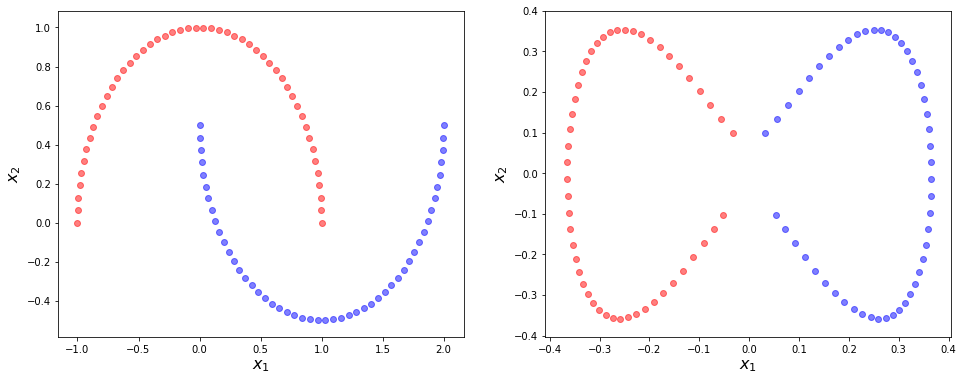

In [28]:
from sklearn.datasets import make_moons
from sklearn.decomposition import KernelPCA

X, y = make_moons(n_samples=100, random_state=123)

mdl = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_kpca = mdl.fit_transform(X)

plt.figure(figsize=(16, 6))

# subplot 1
plt.subplot(1, 2, 1)
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)

plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)

# subplot 2
plt.subplot(1, 2, 2)
plt.scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], color='red', alpha=0.5)
plt.scatter(X_kpca[y==1, 0], X_kpca[y==1, 1], color='blue', alpha=0.5)

plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)

plt.show()

#### Ejercicio
Aplica Kernel PCA sobre el siguiente ejemplo y representa el resultado.

#### Solución

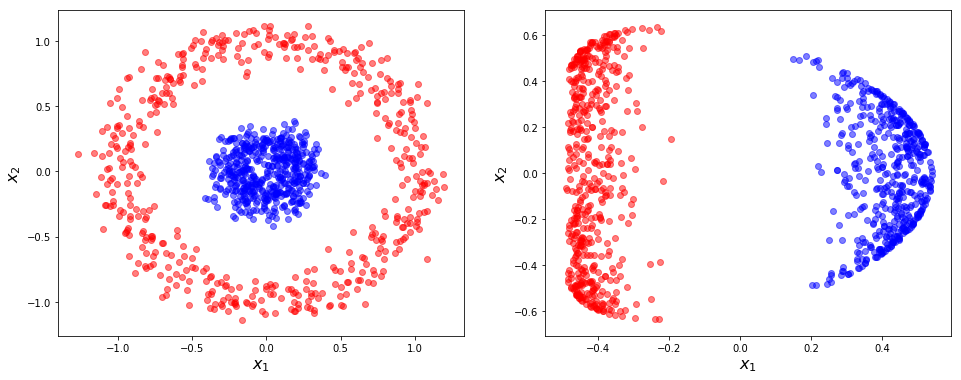

In [29]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)

mdl = KernelPCA(n_components=2, kernel='rbf', gamma=2.0)
X_kpca = mdl.fit_transform(X)

plt.figure(figsize=(16, 6))

# subplot 1
plt.subplot(1, 2, 1)
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)

plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)

# subplot 2
plt.subplot(1, 2, 2)
plt.scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], color='red', alpha=0.5)
plt.scatter(X_kpca[y==1, 0], X_kpca[y==1, 1], color='blue', alpha=0.5)

plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)

plt.show()